# Initial Setup

In [3]:
%%capture
%load_ext autoreload
%autoreload 2

import tqdm
from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import quandl

from IPython.display import Audio
sound_file = '../sound/done.mp3'

import tbats
import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()
sys.path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from regressions import *
from Pmdarima_Model import Pmdarima_Model

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key, api_key

## Get NYSE calendar

In [4]:
NYSE = mcal.get_calendar('NYSE')

## Set up Frequency Variables

### Custom Business Hour

In [5]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [6]:
CBD = NYSE.holidays()
CBD

<CustomBusinessDay>

# YFinance Futures

## Setup / Gather Data

In [7]:
symbol = 'SPY'
f_symbol = 'ES=F'

In [8]:
years = [3, 5, 10, 30]
get_yf_time_series(yf, years, symbol, freq=CBD)

In [9]:
years = [3, 5, 10, 30]
get_yf_time_series(yf, years, f_symbol, freq=CBD, fut=True)

In [10]:
# spy_f_df = yf.download(symbol, start='2011-05-01', end='2021-05-01', progress=False)
# spy_f_df.index = spy_f_df.index.rename('date')
# spy_f_df.columns = ['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume']
# spy_f_df.to_csv('../data/SPY_F_10Y_CBD.csv')

## Load Data from File

### 3Y

In [11]:
spy_df_3Y = load_yf_time_series(yf, 3, symbol, freq=CBD)
spy_f_df_3Y = load_yf_time_series(yf, 3, f_symbol, freq=CBD)

### 5Y

In [12]:
spy_df_5Y = load_yf_time_series(yf, 5, symbol, freq=CBD)
spy_f_df_5Y = load_yf_time_series(yf, 5, f_symbol, freq=CBD)

### 10Y

In [13]:
spy_df_10Y = load_yf_time_series(yf, 10, symbol, freq=CBD)
spy_f_df_10Y = load_yf_time_series(yf, 10, f_symbol, freq=CBD)

In [14]:
# spy_df_10Y = pd.read_csv('../data/SPY_10Y_CBD.csv', index_col='date')
# spy_df_10Y.index = pd.to_datetime(spy_df_10Y.index)

In [15]:
# spy_f_df_10Y = pd.read_csv('../data/SPY_F_10Y_CBD.csv', index_col='date')
# spy_f_df_10Y.index = pd.to_datetime(spy_f_df_10Y.index)

### All

In [16]:
spy_df_all = load_yf_time_series(yf, 30, symbol, freq=CBD)
spy_f_df_all = load_yf_time_series(yf, 30, f_symbol, freq=CBD)

### Treasury Yield Curve

In [17]:
# tsy_df = pd.read_csv('../data/10-year-treasury-bond-rate-yield-chart.csv', index_col='date')
# tsy_df.dropna(inplace=True)
# tsy_df.index = pd.to_datetime(tsy_df.index)
# tsy_df.columns = ['value']

In [18]:
# tsy_all_df = tsy_df.sort_index().truncate(before=spy_df_all.index[0], after=spy_df_all.index[-1])
# tsy_10Y_df = tsy_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
# tsy_5Y_df = tsy_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
# tsy_3Y_df = tsy_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

#### Using Quandl

In [82]:
tsy_symbol = 'USTREASURY/YIELD'

In [107]:
tsy_df = quandl.get(tsy_symbol)
tsy_all_df = tsy_df.copy()
tsy_all_df.index.name = 'date'

In [108]:
tsy_all_df = tsy_all_df.sort_index().truncate(before=spy_df_all.index[0], after=spy_df_all.index[-1])
tsy_10Y_df = tsy_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
tsy_5Y_df = tsy_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
tsy_3Y_df = tsy_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [86]:
tsy_all_df.isna().sum()

1 MO     2130
2 MO     6435
3 MO        3
6 MO        0
1 YR        0
2 YR        0
3 YR        0
5 YR        0
7 YR        0
10 YR       0
20 YR     170
30 YR     994
dtype: int64

In [109]:
tsy_all_df = tsy_all_df.asfreq(CBD).interpolate()

In [110]:
tsy_all_df_6M = tsy_all_df['6 MO']
tsy_all_df_1Y = tsy_all_df['1 YR']
tsy_all_df_2Y = tsy_all_df['2 YR']
tsy_all_df_3Y = tsy_all_df['3 YR']
tsy_all_df_5Y = tsy_all_df['5 YR']
tsy_all_df_7Y = tsy_all_df['7 YR']
tsy_all_df_10Y = tsy_all_df['10 YR']

In [97]:
tsy_all_df.isna().sum()

1 MO     2146
2 MO     6476
3 MO        0
6 MO        0
1 YR        0
2 YR        0
3 YR        0
5 YR        0
7 YR        0
10 YR       0
20 YR     170
30 YR       0
dtype: int64

In [25]:
tsy_df.value.corr(spy_df_all.close)

AttributeError: 'DataFrame' object has no attribute 'value'

In [ ]:
tsy_df['1 MO'].corr(spy_df_all.close)

In [ ]:
tsy_df['2 MO'].corr(spy_df_all.close)

In [ ]:
tsy_df['3 MO'].corr(spy_df_all.close)

In [ ]:
tsy_df['6 MO'].corr(spy_df_all.close)

In [ ]:
tsy_df['1 YR'].corr(spy_df_all.close)

In [ ]:
tsy_df['2 YR'].corr(spy_df_all.close)

In [ ]:
tsy_df['3 YR'].corr(spy_df_all.close)

In [ ]:
tsy_df['5 YR'].corr(spy_df_all.close)

In [ ]:
tsy_df['7 YR'].corr(spy_df_all.close)

In [ ]:
tsy_q_df['10 YR']

In [ ]:
tsy_df['10 YR'].corr(spy_df_all.close)

In [ ]:
tsy_df['20 YR'].corr(spy_df_all.close)

In [ ]:
tsy_df['30 YR'].corr(spy_df_all.close)

## Inflation Indexed

In [37]:
tsy_ii_symbol = 'FRED/DFII10'
tsy_ii_df = quandl.get(tsy_ii_symbol)
tsy_ii_df

,Value
Date,
2003-01-02,2.43
2003-01-03,2.43
2003-01-06,2.46
2003-01-07,2.42
2003-01-08,2.29
...,...
2021-04-30,-0.76
2021-05-03,-0.79
2021-05-04,-0.81


### Fed Funds Rate

In [ ]:
# fed_df = pd.read_csv('../data/fed-funds-rate-historical-chart.csv', index_col='date')
# fed_df.dropna(inplace=True)
# fed_df.index = pd.to_datetime(fed_df.index)
# fed_df.columns = ['value']

In [ ]:
# fed_all_df = fed_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
# fed_10Y_df = fed_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
# fed_5Y_df = fed_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
# fed_3Y_df = fed_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

#### Quandl

In [34]:
fed_symbol = 'FRED/FEDFUNDS'
fed_symbol_daily = 'FRED/DFF'
fed_df = quandl.get(fed_symbol)
fed_d_df = quandl.get(fed_symbol_daily)
fed_df.isna().sum()

Value    0
dtype: int64

In [36]:
fed_df

,Value
Date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
...,...
2020-11-01,0.09
2020-12-01,0.09
2021-01-01,0.09


In [35]:
fed_d_df

,Value
Date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88
...,...
2021-05-02,0.05
2021-05-03,0.06
2021-05-04,0.06


In [27]:
fed_all_df = fed_df.sort_index().truncate(before=spy_df_all.index[0],after=spy_df_all.index[-1])
fed_10Y_df = fed_all_df.sort_index().truncate(before=spy_df_10Y.index[0])
fed_5Y_df = fed_10Y_df.sort_index().truncate(before=spy_df_5Y.index[0])
fed_3Y_df = fed_5Y_df.sort_index().truncate(before=spy_df_3Y.index[0])

In [28]:
fed_all_df = fed_all_df.asfreq(CBD)
fed_10Y_df = fed_10Y_df.asfreq(CBD)
fed_5Y_df = fed_5Y_df.asfreq(CBD)
fed_3Y_df = fed_3Y_df.asfreq(CBD)

In [29]:
fed_all_df.isna().sum()

Value    6854
dtype: int64

In [30]:
fed_all_df[fed_all_df.isna()]

,Value
Date,
1993-02-01,NaN
1993-02-02,NaN
1993-02-03,NaN
1993-02-04,NaN
1993-02-05,NaN
...,...
2021-02-23,NaN
2021-02-24,NaN
2021-02-25,NaN


## Data Preparation

### EDA

In [18]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-01,2646.25,2658.00,2623.25,2652.25,2652.25,1323628
2018-05-02,2655.50,2658.50,2624.25,2627.50,2627.50,1427995
2018-05-03,2626.75,2636.25,2591.25,2631.75,2631.75,2146587
2018-05-04,2631.75,2669.50,2612.25,2663.00,2663.00,1699202
2018-05-07,2662.75,2681.50,2661.25,2670.00,2670.00,1148919
...,...,...,...,...,...,...
2021-05-03,4181.50,4202.50,4181.00,4185.75,4185.75,1256240
2021-05-04,4184.25,4185.50,4120.50,4158.25,4158.25,2003587
2021-05-05,4158.25,4180.00,4153.00,4160.00,4160.00,1418246


In [19]:
spy_df_3Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [20]:
tsy_3Y_df['value'].corr(spy_df_3Y.close)

-0.5202232204435858

In [21]:
tsy_5Y_df['value'].corr(spy_df_5Y.close)

-0.4165688132569297

In [22]:
tsy_10Y_df['value'].corr(spy_df_10Y.close)

-0.30806204035047036

In [23]:
tsy_25Y_df['value'].corr(spy_df_25Y.close)

-0.6677946042523104

In [133]:
 np.linspace(0,20,11)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])

In [145]:
np.arange(x1_range[0],x1_range[1],11)

array([200, 211, 222, 233, 244, 255, 266, 277, 288, 299, 310, 321, 332,
       343, 354, 365, 376, 387, 398, 409, 420])

In [273]:
np.linspace(225, 450, 10)

array([225., 250., 275., 300., 325., 350., 375., 400., 425., 450.])

In [282]:
np.linspace(0, 2.5, 11)

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ])

In [316]:
np.linspace(0, 4, 9)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [350]:
', '.join(labels)

'SPY 3Y Close, SPY Futures 3Y Close, 10Y Treasury Yield, Fed Funds Rate'

In [281]:
spy_range = (200, 450)
[x*2 for x in spy_range]

[400, 900]

In [216]:
tsy_3Y_df.value.max(), fed_3Y_df.value.max()

(3.24, 2.45)

In [378]:
kwargs = {'axes':[ax1, ax2, ax3, ax4], 'data':[spy_df_3Y.close, spy_f_df_3Y.f_close, tsy_3Y_df.value, fed_3Y_df.value]}

In [395]:
kwargs = {'data':[spy_df_3Y.close, spy_f_df_3Y.f_close, tsy_3Y_df.value, fed_3Y_df.value]}

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


In [389]:
spy_df_3Y

,open,high,low,close,adj_close,volume
date,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900
...,...,...,...,...,...,...
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300
2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700


Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


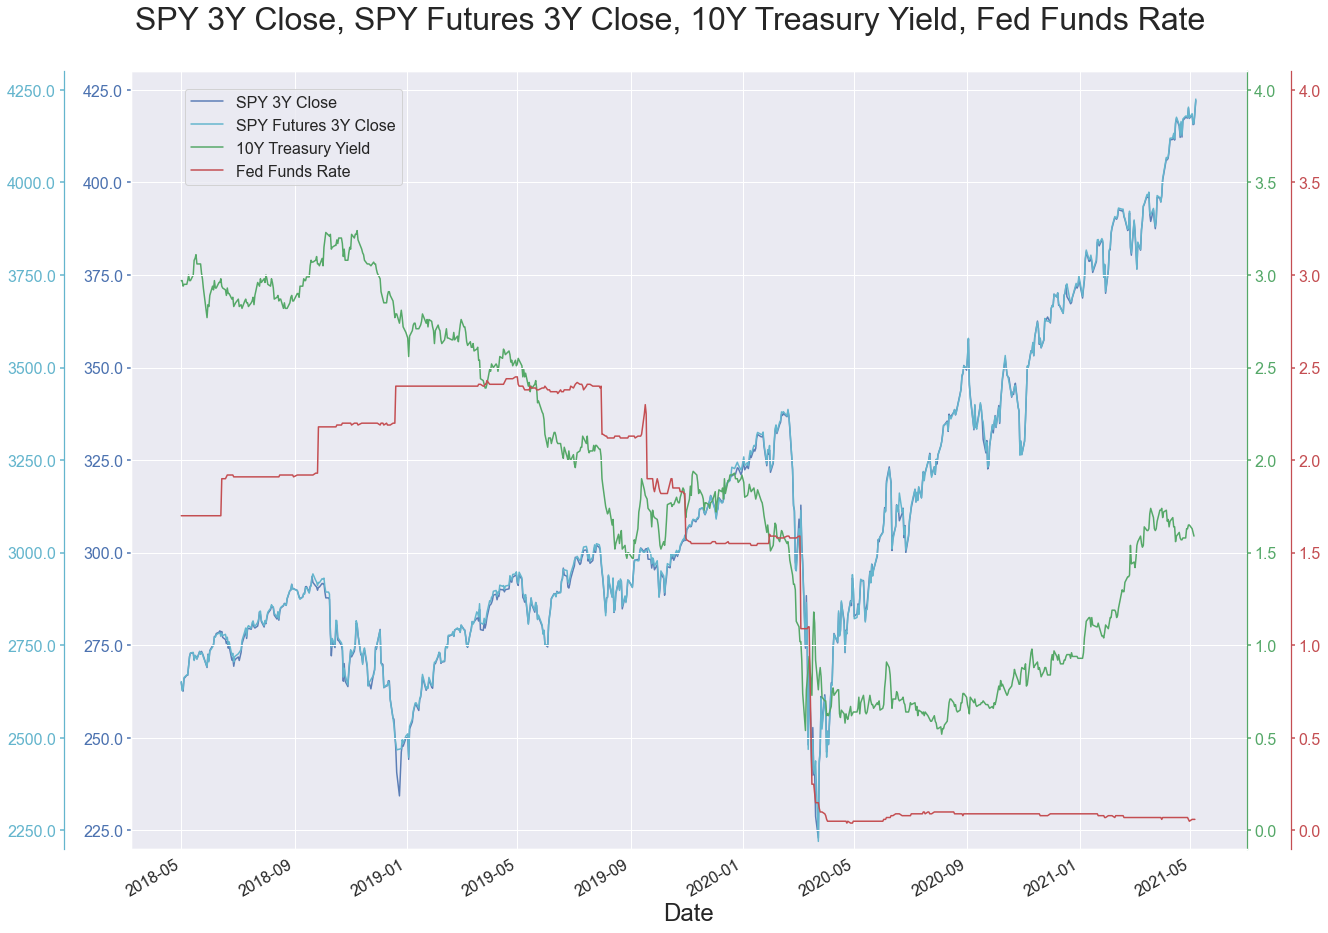

In [398]:
plot_4_time_series(**kwargs)

NameError: name 'TOP' is not defined

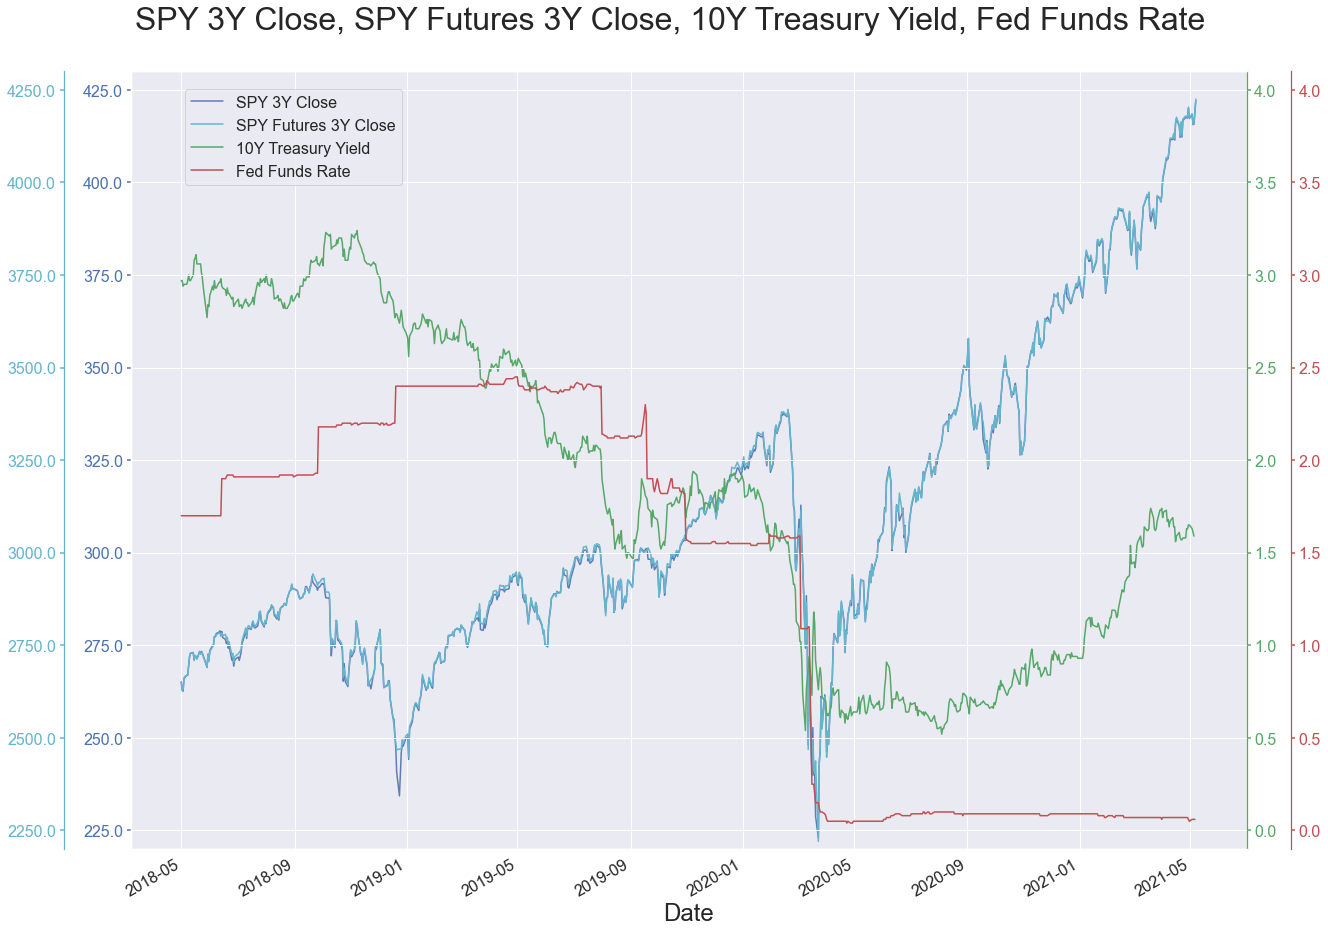

In [367]:
fig, ax1 = plt.subplots(figsize=(20,15))
axes = [ax1, ax2, ax3, ax4]
data = [spy_df_3Y.close, spy_f_df_3Y.f_close, tsy_3Y_df.value, fed_3Y_df.value]
colors = ['b','c','g','r']
labels = ['SPY 3Y Close', 'SPY Futures 3Y Close', '10Y Treasury Yield', 'Fed Funds Rate']
ylabels = ['SPY 3Y Close (USD)', 'SPY Futures 3Y Close (USD)', '10Y Treasury Yield %', 'Fed Funds Rate %']
alpha = [0.9, 1, 1, 1]
spy_range = (225, 425)
yield_range = (0, 4)
num_ticks = 9
y_ranges = [spy_range, [10*x for x in spy_range], yield_range, yield_range]
tkw = dict(size=4, width=1.5, labelsize=16)
for n, ax in enumerate(axes):
    if n>0:
        ax = ax1.twinx()
    if n==1:
        ax.spines['left'].set_position(("axes", -0.06))
        ax.spines['left'].set_edgecolor(colors[n])
        ax.yaxis.set_label_position("left")
        ax.yaxis.tick_left()
    if n>1:
        ax.spines['right'].set_position(("axes", 1 + 0.04*(n-2)))
        ax.spines['right'].set_edgecolor(colors[n])
    data[n].plot(ax=ax, color=colors[n], alpha=alpha[n], label=labels[n])
    y_ticks = np.linspace(y_ranges[n][0], y_ranges[n][1], num_ticks)
    pad = (y_ranges[n][1] - y_ranges[n][0]) / (num_ticks-1)/5
    y_lim = (y_ranges[n][0]-pad, y_ranges[n][1]+pad)
    ax.set_yticklabels(y_ticks)
    ax.set_yticks(y_ticks)
    ax.set_ylim(y_lim)
    ax.tick_params(axis='y', colors=colors[n], **tkw)

ax1.set_xlabel('Date', size=24)
ax1.tick_params(axis='x', **tkw)
fig.suptitle(', '.join(labels), size=32)
fig.subplots_adjust(top=0.92)
fig.legend(loc=(0.139, 0.8007), prop={"size":16})
plt.savefig(f'{TOP}/images/SPY_3Y_Comparison_Graph.png')
# fig.legend(loc='upper left', borderaxespad=7)

'date'

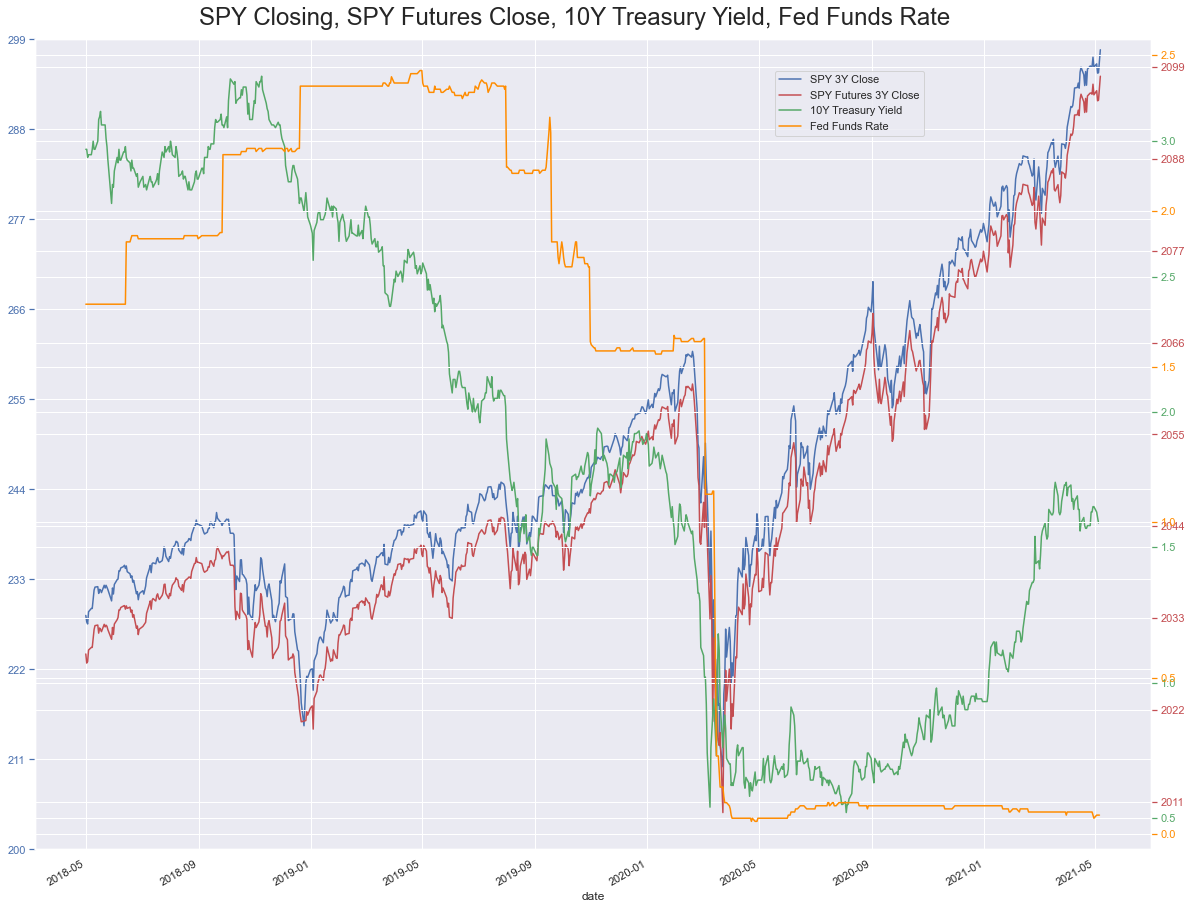

In [155]:
fig, ax1 = plt.subplots(figsize=(20,15))
spy_df_3Y.close.plot(ax=ax1, color ='b', label='SPY 3Y Close')
ax1.tick_params(axis='y', colors='b')
ax1.set_ylim(x1_range)
x1_range = (200,425)
ax1.set_yticklabels(np.arange(x1_range[0],x1_range[1],11))

ax2 = ax1.twinx()
spy_f_df_3Y.f_close.plot(ax=ax2, color = 'r', label='SPY Futures 3Y Close')
ax2.tick_params(axis='y', colors='r')
x2_range = (2000,4250)
ax2.set_yticklabels(np.arange(x2_range[0],x2_range[1],11))

ax3 = ax1.twinx()
tsy_3Y_df.value.plot(ax=ax3, color = 'g', label='10Y Treasury Yield')
ax3.tick_params(axis='y', colors='g')

ax4 = ax1.twinx()
fed_3Y_df.value.plot(ax=ax4, color = 'darkorange', label='Fed Funds Rate')
ax4.tick_params(axis='y', colors='darkorange')
ax4.set_ylim(-0.05, 2.55)

fig.suptitle('SPY Closing, SPY Futures Close, 10Y Treasury Yield, Fed Funds Rate', size=24)
fig.subplots_adjust(top=0.95)
fig.legend(loc=(0.65, 0.85))

In [27]:
spy_df_3Y

,open,high,low,close,adj_close,volume
date,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900
...,...,...,...,...,...,...
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300
2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700


In [28]:
spy_df_5Y

,open,high,low,close,adj_close,volume
date,,,,,,
2016-05-02,206.919998,208.179993,206.410004,207.970001,189.178101,62188000
2016-05-03,206.520004,206.800003,205.279999,206.160004,187.531647,106422100
2016-05-04,204.990005,205.850006,204.419998,205.009995,186.485535,92243800
2016-05-05,205.559998,205.979996,204.470001,204.970001,186.449203,67619200
2016-05-06,204.059998,205.770004,203.880005,205.720001,187.131424,89315000
...,...,...,...,...,...,...
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300
2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700


In [29]:
spy_df_3Y.index[-1]

Timestamp('2021-05-07 00:00:00')

In [30]:
spy_df_5Y.truncate(before=spy_df_3Y.index[0])

,open,high,low,close,adj_close,volume
date,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900
...,...,...,...,...,...,...
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300
2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700


### Set up Frequency

In [31]:
spy_df_3Y = spy_df_3Y.asfreq(CBD)
spy_df_5Y = spy_df_5Y.asfreq(CBD)
spy_df_10Y = spy_df_10Y.asfreq(CBD)
spy_df_25Y = spy_df_25Y.asfreq(CBD)

In [32]:
spy_f_df_3Y = spy_f_df_3Y.asfreq(CBD)
spy_f_df_5Y = spy_f_df_5Y.asfreq(CBD)
spy_f_df_10Y = spy_f_df_10Y.asfreq(CBD)
spy_f_df_25Y = spy_f_df_25Y.asfreq(CBD)

In [434]:
tsy_df = tsy_df.asfreq(CBD)

In [438]:
tsy_df[tsy_df['10 YR'].isna()]['10 YR']

Date
1990-01-15   NaN
1990-10-08   NaN
1990-11-12   NaN
1991-01-21   NaN
1991-10-14   NaN
              ..
2018-11-12   NaN
2019-10-14   NaN
2019-11-11   NaN
2020-10-12   NaN
2020-11-11   NaN
Name: 10 YR, Length: 66, dtype: float64

In [33]:
spy_df_3Y.isna().sum(), spy_df_5Y.isna().sum(), spy_df_10Y.isna().sum(), spy_df_25Y.isna().sum()

(open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64,
 open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64,
 open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64,
 open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64)

In [34]:
spy_f_df_5Y[spy_f_df_5Y.f_close.isna()]

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2016-10-10,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-11,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-24,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-23,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-24,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-29,NaN,NaN,NaN,NaN,NaN,NaN


### Impute Missing Values

In [35]:
# spy_df_3Y = spy_df_3Y.interpolate()
spy_f_df_3Y = spy_f_df_3Y.interpolate()
spy_f_df_5Y = spy_f_df_5Y.interpolate()
spy_f_df_10Y = spy_f_df_10Y.interpolate()
spy_f_df_25Y = spy_f_df_25Y.interpolate()

### Create Time Series for `Close`, `Volume`

In [36]:
df_f_3Y_close = spy_f_df_3Y.f_close
df_f_3Y_vol = spy_f_df_3Y.f_volume
df_f_5Y_close = spy_f_df_5Y.f_close
df_f_5Y_vol = spy_f_df_5Y.f_volume
df_f_10Y_close = spy_f_df_10Y.f_close
df_f_10Y_vol = spy_f_df_10Y.f_volume

In [37]:
df_f_5Y_close, df_f_5Y_vol

(date
 2016-05-02    2074.25
 2016-05-03    2057.00
 2016-05-04    2047.00
 2016-05-05    2044.00
 2016-05-06    2052.75
                ...   
 2021-05-03    4185.75
 2021-05-04    4158.25
 2021-05-05    4160.00
 2021-05-06    4194.25
 2021-05-07    4225.25
 Freq: C, Name: f_close, Length: 1264, dtype: float64,
 date
 2016-05-02    1306173.0
 2016-05-03    1827577.0
 2016-05-04    1557981.0
 2016-05-05    1433289.0
 2016-05-06    1813432.0
                 ...    
 2021-05-03    1256240.0
 2021-05-04    2003587.0
 2021-05-05    1418246.0
 2021-05-06    1751616.0
 2021-05-07    1751616.0
 Freq: C, Name: f_volume, Length: 1264, dtype: float64)

## Data Exploration

### Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



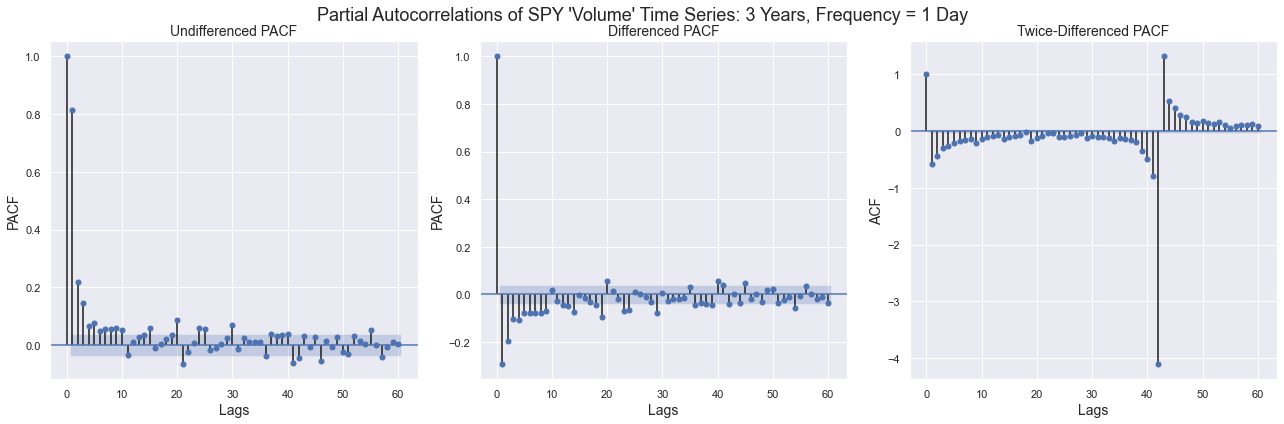

In [351]:
plot_pacf_with_diff(df_full_10Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

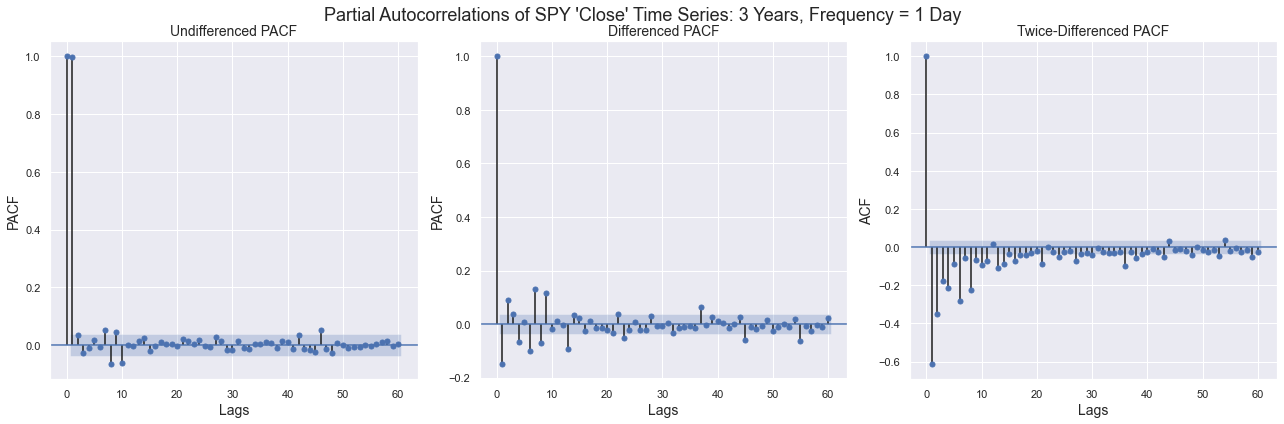

In [352]:
plot_pacf_with_diff(df_full_10Y_close.interpolate(), 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

### Plot ACF

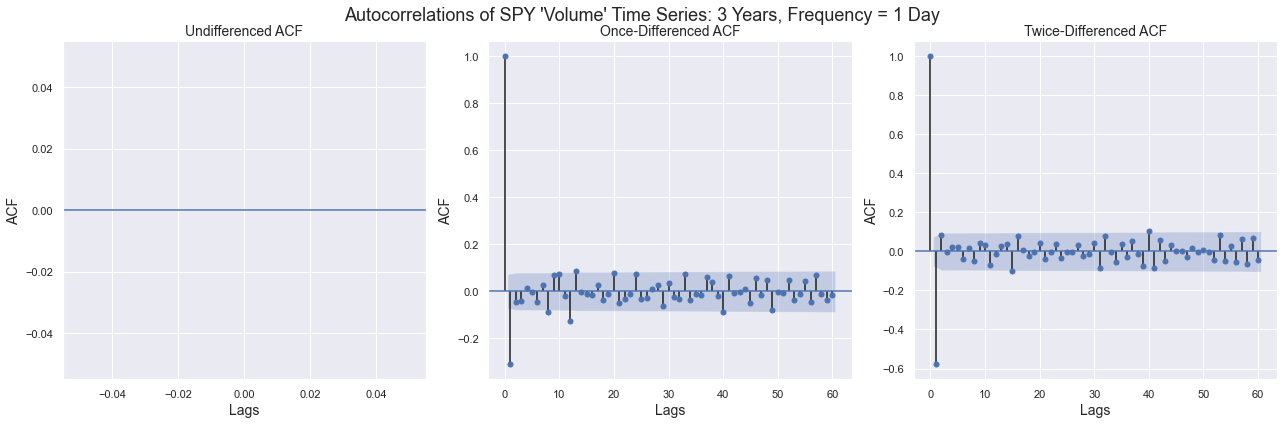

In [21]:
plot_acf_with_diff(df_full_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

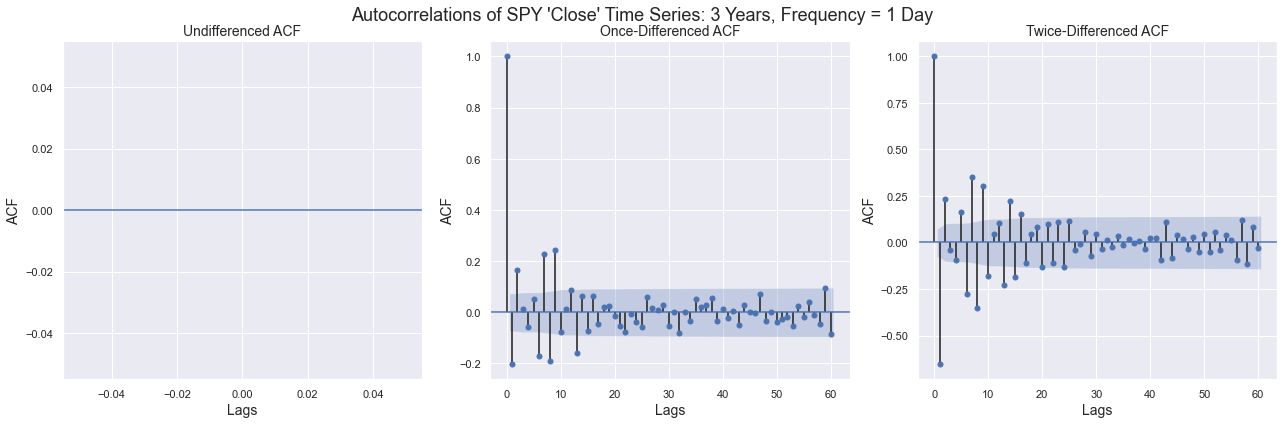

In [22]:
plot_acf_with_diff(df_full_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

### Plot Seasonal Decomposition

#### 3 Years, Freq = Custom Business Day, Yearly Seasonality

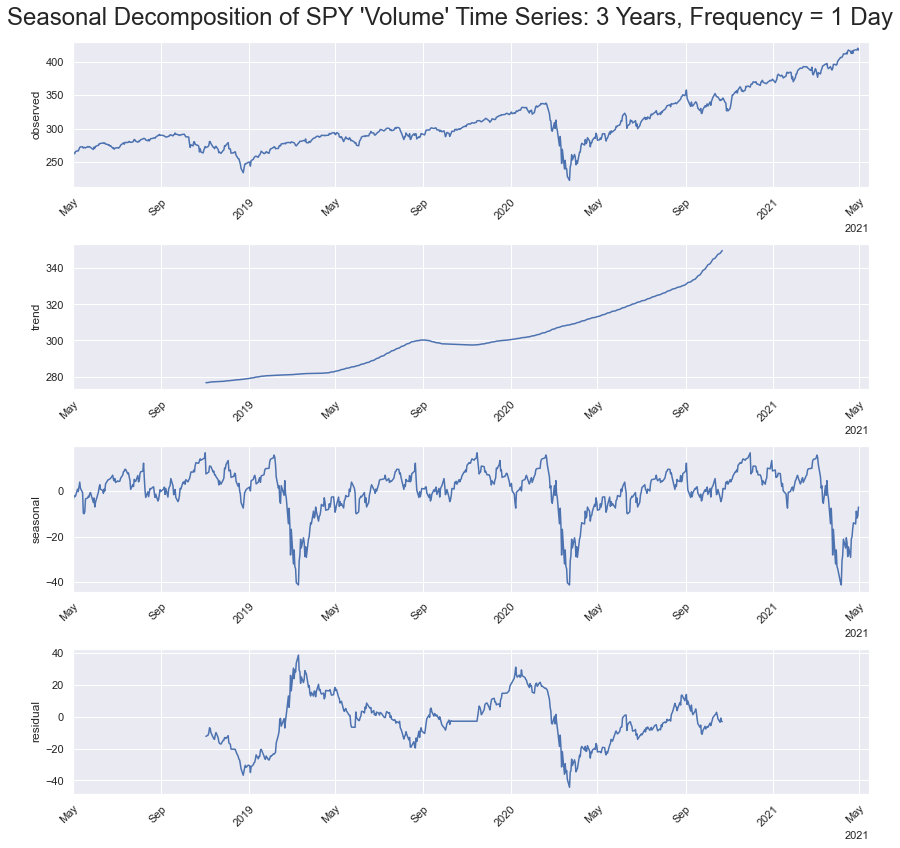

In [23]:
plot_seasonal_decomposition(df_full_3Y_close.dropna(), 'SPY \'Volume\'', 3, 'years', '1 Day', 261)

#### 5 Years, Freq = Custom Business Day, Yearly Seasonality

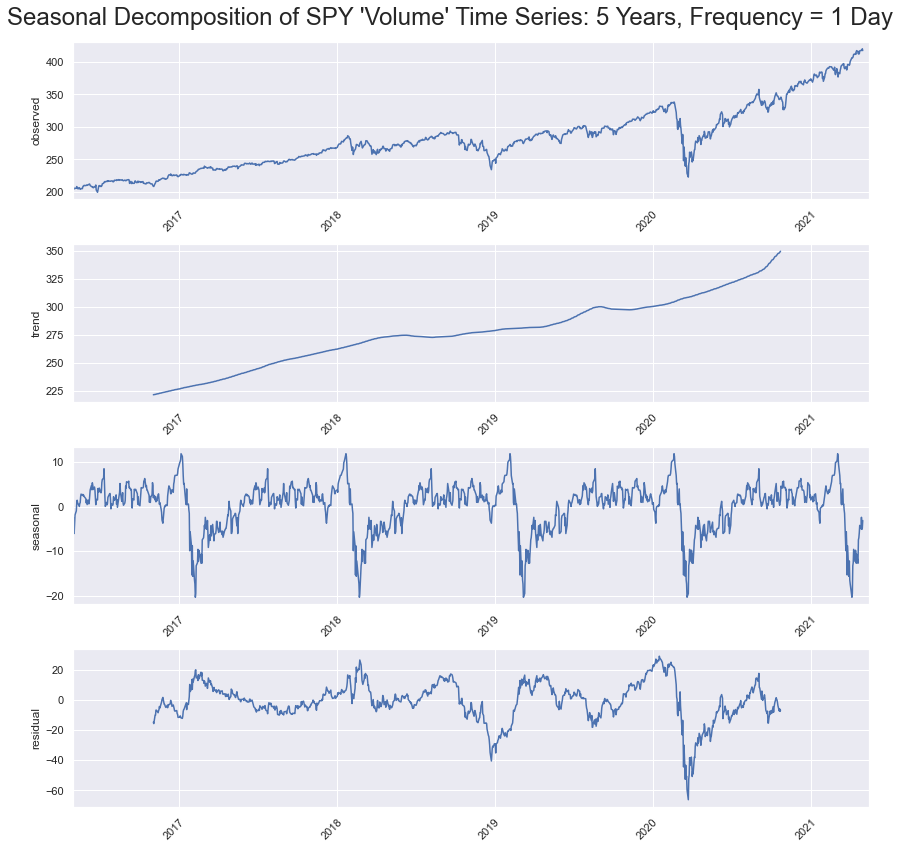

In [24]:
plot_seasonal_decomposition(df_full_5Y_close.dropna(), 'SPY \'Volume\'', 5, 'years', '1 Day', 261)

#### 10 Years, Freq = Custom Business Day, Yearly Seasonality

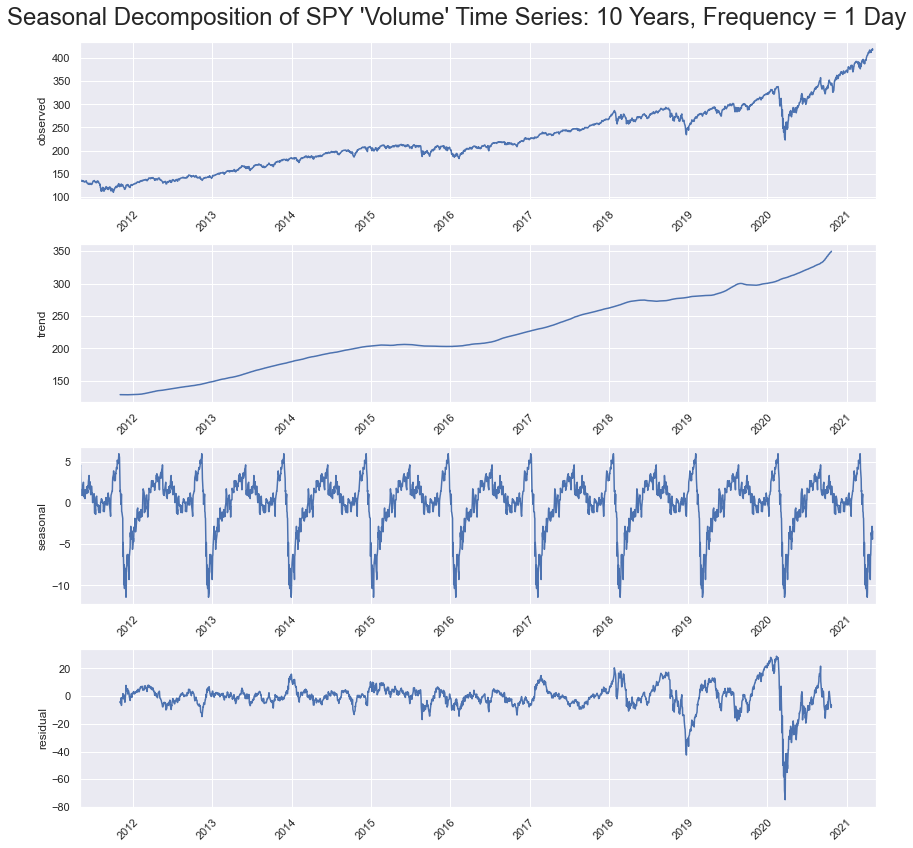

In [25]:
plot_seasonal_decomposition(df_full_10Y_close.dropna(), 'SPY \'Volume\'', 10, 'years', '1 Day', 261)

### Build DF combining SPY and SPY F

In [43]:
spy_cat_3Y_df = spy_df_3Y.join(spy_f_df_3Y)
spy_cat_3Y_df

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


### Build DF combining the two with one day offset

In [38]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-01,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-02,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-03,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-04,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-07,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...
2021-05-03,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-04,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-05,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


In [39]:
spy_f_df_3Y_1d_back = spy_f_df_3Y.copy()
spy_f_df_3Y_1d_back.index = spy_f_df_3Y_1d_back.index+CBD
# spy_f_df_3Y_1d_back.drop(spy_f_df_3Y_1d_back.index[-1], axis=0, inplace=True)
spy_f_df_3Y_1d_back

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-02,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-03,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-04,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-07,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-08,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...
2021-05-04,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0
2021-05-05,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0
2021-05-06,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0


In [40]:
df_1d_back = spy_df_3Y.copy()
df_1d_back = spy_f_df_3Y_1d_back.join(df_1d_back)
df_1d_back

,f_open,f_high,f_low,f_close,f_adj_close,f_volume,open,high,low,close,adj_close,volume
date,,,,,,,,,,,,
2018-05-02,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0
2018-05-03,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0
2018-05-04,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0
2018-05-07,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0
2018-05-08,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0,266.500000,267.329987,265.149994,266.920013,252.547226,67499200.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-04,4181.50,4202.50,4181.00,4185.75,4185.75,1256240.0,416.070007,416.600006,411.670013,415.619995,415.619995,101591200.0
2021-05-05,4184.25,4185.50,4120.50,4158.25,4158.25,2003587.0,417.380005,417.630005,415.149994,415.750000,415.750000,39960700.0
2021-05-06,4158.25,4180.00,4153.00,4160.00,4160.00,1418246.0,415.829987,419.209991,413.679993,419.070007,419.070007,74321400.0


### Create Diffs DF

In [44]:
spy_cat_3Y_df_diff = pd.DataFrame(index = spy_cat_3Y_df.index)

In [45]:
spy_cat_3Y_df_diff['d_close'] = spy_cat_3Y_df.close.diff()
spy_cat_3Y_df_diff['d_f_close'] = spy_cat_3Y_df.f_close.diff()
spy_cat_3Y_df_diff['d_open'] = spy_cat_3Y_df.open.diff()
spy_cat_3Y_df_diff['d_f_open'] = spy_cat_3Y_df.f_open.diff()

In [46]:
spy_cat_3Y_df_diff

,d_close,d_f_close,d_open,d_f_open
date,,,,
2018-05-01,NaN,NaN,NaN,NaN
2018-05-02,-1.779999,-24.75,0.890015,9.25
2018-05-03,-0.580017,4.25,-2.500000,-28.75
2018-05-04,3.399994,31.25,-0.740021,5.00
2018-05-07,0.900024,7.00,5.370026,31.00
...,...,...,...,...
2021-05-03,0.900024,11.25,1.799988,-19.25
2021-05-04,-2.580017,-27.50,-3.359985,2.75
2021-05-05,0.130005,1.75,1.309998,-26.00


In [47]:
spy_df_10Y.shape[0]/10

252.2

### Check Correlations between SPY and SPY Futures

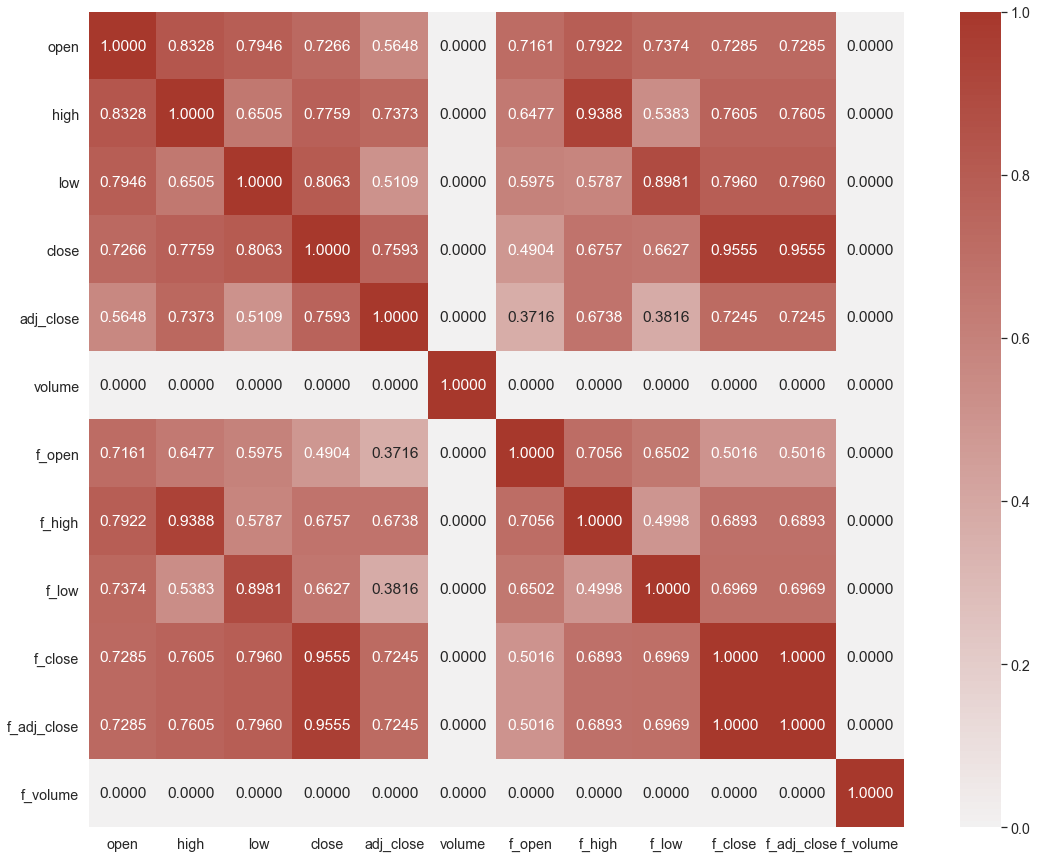

In [50]:
matrix = spy_cat_3Y_df.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**150, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

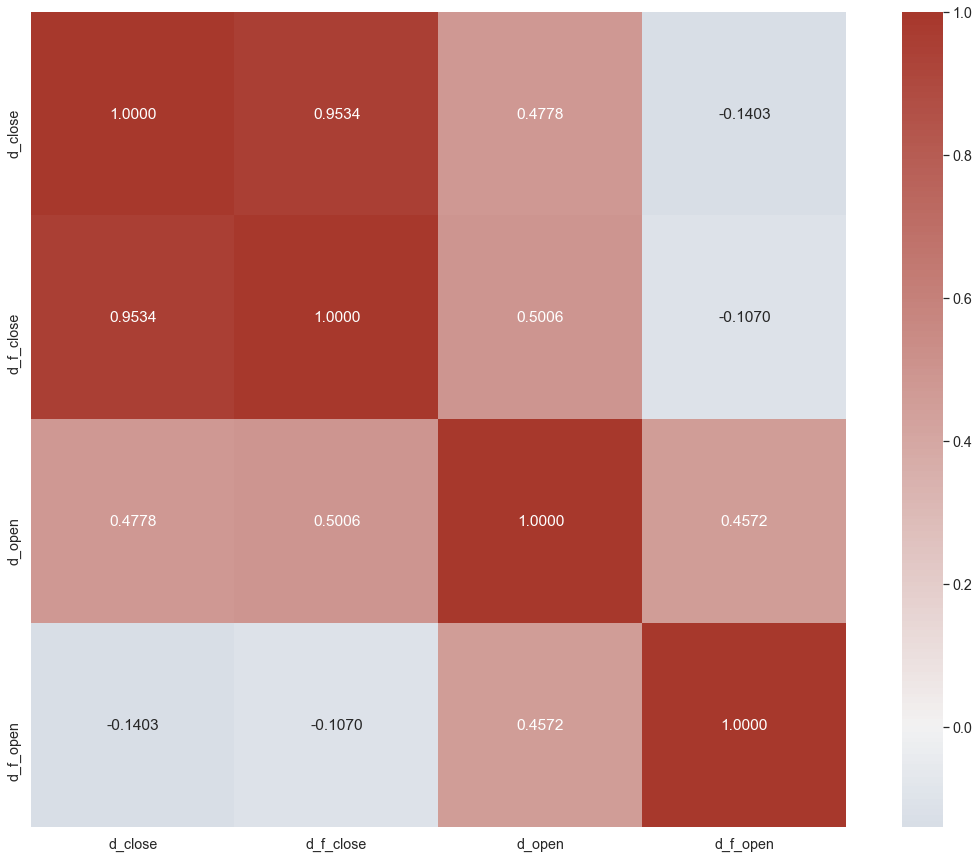

In [51]:
matrix = spy_cat_3Y_df_diff.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

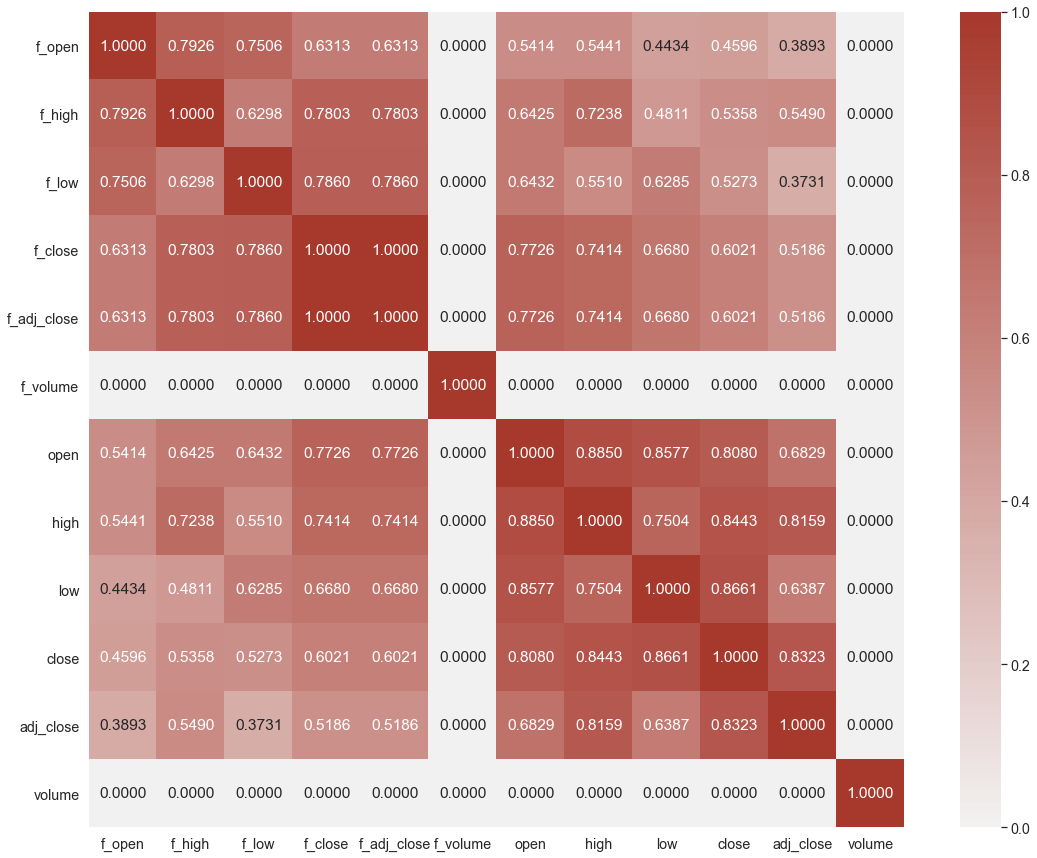

In [52]:
matrix = df_1d_back.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**100, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

# Modeling

## pmdarima

### Treasury Exogenous Variables

In [111]:
tsy_all_df_10Y.index

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-03', '2021-05-04', '2021-05-05',
               '2021-05-06', '2021-05-07'],
              dtype='datetime64[ns]', name='date', length=7120, freq='C')

In [112]:
pam_tsy_all_10Y = Pmdarima_Model(tsy_all_df_10Y, 'TSY 10Y Note',
               n=28, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, #trend='t', k=4,
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1


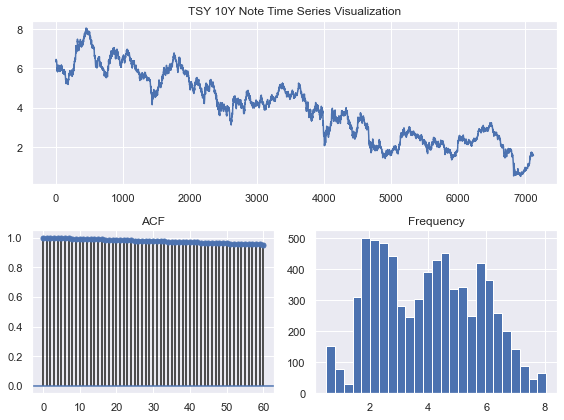

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15830.010, Time=30.68 sec
First viable model found (-15830.010)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15829.618, Time=10.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15829.105, Time=12.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15829.211, Time=11.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15830.769, Time=15.14 sec
New best model found (-15830.769 < -15830.010)
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15828.644, Time=19.86 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 100.756 seconds
Saved best AutoARIMA model as /Users/wax/Documents/Class

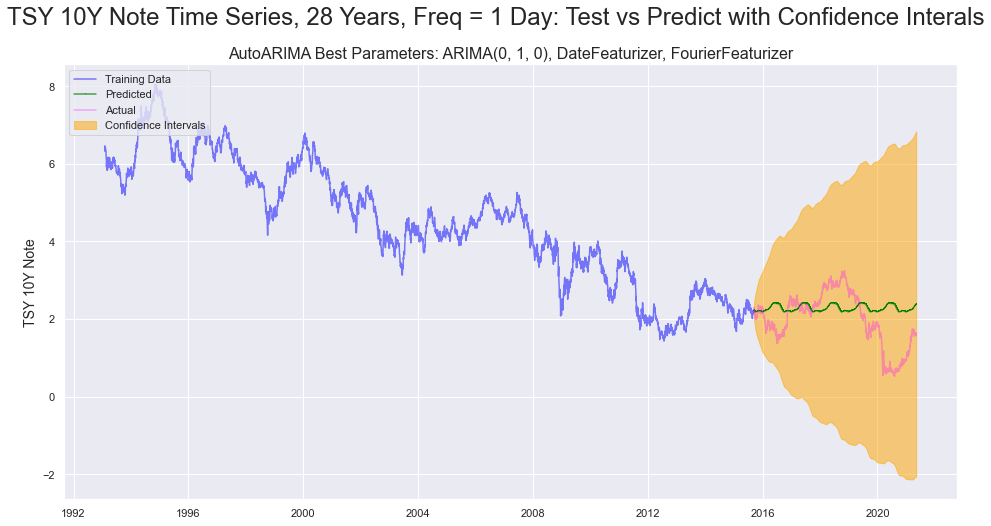

In [113]:
pam_tsy_all_10Y_close_AA_pipe = pam_tsy_all_10Y_close.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)

ARIMA(0, 1, 0), DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on TSY 10Y Note Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: -20523.139
Test RMSE: 0.043
This is 0.962% of the avg observed value.
Test SMAPE: 2.014%




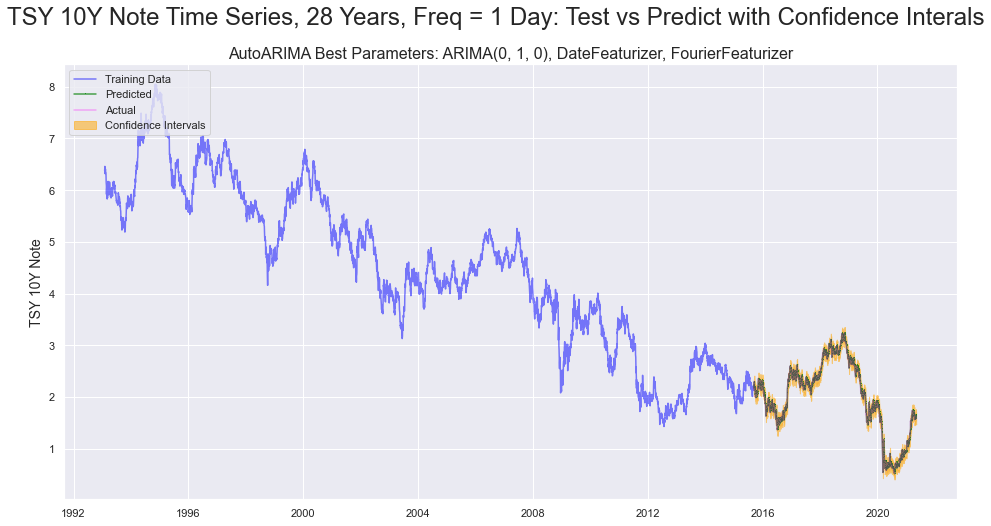

In [119]:
AIC, RMSE, RMSE_pc, SMAPE = pam_tsy_all_10Y.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [120]:
pam_tsy_all_10Y.conf_ints

Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..


[[2.107867779974327, 2.3434185561844196],
 [2.0780342394087, 2.3135645065937696],
 [2.0546956571061945, 2.290225924291264],
 [2.158404124059683, 2.3939343912447524],
 [2.178105899996669, 2.4136361671817386],
 [2.0892414928425658, 2.324771760027635],
 [2.0094707732149426, 2.2450010404000884],
 [2.0761870032230845, 2.3117172704082303],
 [2.019940046794054, 2.2554703139792],
 [2.0396758501686776, 2.2752061173538234],
 [2.0108346980488156, 2.2463649652339677],
 [2.051076330015546, 2.286606597200698],
 [1.9777939703952168, 2.213324237580369],
 [1.9315375387860212, 2.167067805971173],
 [1.9479555722280018, 2.1834858394131538],
 [1.9323812681135535, 2.1679115352987055],
 [1.8725820216515525, 2.1081122888367045],
 [1.9492490291215758, 2.184779296306728],
 [1.932932706126795, 2.168462973311947],
 [1.9625797203470245, 2.1981099875321766],
 [2.0036312407210617, 2.2391615079062137],
 [2.0037480454038206, 2.2392783125889726],
 [1.970324541758468, 2.20585480894362],
 [1.943911965692291, 2.1794422328

## TBATS

In [40]:
if __name__ == '__main__':
    tb = tbats.TBATS(seasonal_periods=(3*30.436875, 365.25))
    tb

In [75]:
# X_train, X_test, y_train, y_test = train_test_split(spy_df_3Y.close, test_size = .20, random_state = 729)
train, test = train_test_split_data(spy_df_10Y.close, train_size = 80)
train, test

(date
 2011-05-02    136.220001
 2011-05-03    135.729996
 2011-05-04    134.830002
 2011-05-05    133.610001
 2011-05-06    134.199997
                  ...    
 2019-05-02    291.179993
 2019-05-03    294.029999
 2019-05-06    292.820007
 2019-05-07    287.929993
 2019-05-08    287.529999
 Name: close, Length: 2018, dtype: float64,
 date
 2019-05-09    286.660004
 2019-05-10    288.100006
 2019-05-13    280.859985
 2019-05-14    283.399994
 2019-05-15    285.059998
                  ...    
 2021-05-03    418.200012
 2021-05-04    415.619995
 2021-05-05    415.750000
 2021-05-06    419.070007
 2021-05-07    422.119995
 Name: close, Length: 504, dtype: float64)

In [76]:
tb_mod = tb.fit(train)

In [77]:
y_hat, conf_ints = tb_mod.forecast(steps=152, confidence_level=0.95)

# Print mean absolute errors
print('MAE (in sample)', np.mean(np.abs(tb_mod.resid)))
print('MAE (forecast)', np.mean(np.abs(y_hat - test)))

ylabel='SPY_Close_TBATS'
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train, color='blue', alpha=0.5, label='Training Data')
ax.plot(test.index, y_hat, color='green', marker=',', alpha=0.7, label='Predicted')
ax.plot(test, color='magenta', alpha=0.3, label='Actual')
if conf_ints:
    conf_int = np.asarray(conf_ints)
    ax.fill_between(test.index,
             conf_ints['upper_bound'], conf_ints['lower_bound'],
             alpha=0.5, color='orange',
             label="Confidence Intervals")
ax.legend(loc='upper left', borderaxespad=0.5)
fig.suptitle(f'{ylabel} Time Series, 3 Years, Freq = 1 Day: Test vs Predict with Confidence Interals\n', size=24)
ax.set_ylabel(ylabel, size=14)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..
MAE (in sample) 1.2088346772288139


ValueError: operands could not be broadcast together with shapes (152,) (504,) 

## Logistic Regression

In [56]:
y_forecasted = tb_mod.forecast(steps=14)

In [57]:
y_forecasted

array([334.17013971, 333.20464908, 332.81299236, 332.96132464,
       332.88464521, 332.91194596, 332.89888889, 332.90382327,
       332.90157546, 332.90245771, 332.90206794, 332.90222464,
       332.90215674, 332.90218446])

### SPY vs SPY Future - no offset¶

In [76]:
X, y = create_data_sets(spy_f_df_3Y, spy_df_3Y, verbose=1)

regressions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
X:
              f_open   f_high    f_low  f_close  f_adj_close   f_volume  change
date                                                                          
2018-05-01  2646.25  2658.00  2623.25  2652.25      2652.25  1323628.0       0
2018-05-02  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0       0
2018-05-03  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0       0
2018-05-04  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0       1
2018-05-07  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0       1
...             ...      ...      ...      ...          ...        ...     ...
2021-05-03  4181.50  4202.50  4181.00  4185.75      4185.75  1256240.0       1
2021-05-04  4184.25  4185.50  4120.50  4158.25      4158.25  2003587.0       0
2021-05-05  4158.25  4180.00  4153.00  4160.00      4160.00  1418246.0  

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 729)
X_y_train_test = train_test_split(X, y, test_size = .20, random_state = 729)
X_y_train_test[0]

,f_open,f_high,f_low,f_close,f_adj_close,f_volume,change
date,,,,,,,
2018-12-12,2632.500,2686.50,2631.75,2652.50,2652.50,1900862.0,1
2018-10-01,2922.500,2942.00,2922.50,2930.00,2930.00,1239963.0,1
2020-12-24,3678.125,3717.00,3663.50,3704.50,3704.50,891236.5,1
2021-04-21,4121.250,4167.25,4113.00,4164.75,4164.75,1505474.0,1
2019-02-05,2719.500,2737.75,2716.25,2731.00,2731.00,1225737.0,1
...,...,...,...,...,...,...,...
2018-06-18,2780.000,2786.75,2761.25,2779.75,2779.75,993118.0,0
2020-06-15,2992.750,3079.25,2935.00,3073.00,3073.00,1947459.0,1
2019-04-02,2868.500,2873.75,2862.25,2867.00,2867.00,859942.0,1


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume',
       'change'],
      dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [       nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan        nan        nan 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan 0.43256271 0.86180884 0.78291795        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        n

{'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  7
Model score:  1.0
Accuracy score:  1.0
Model F1 (micro):  1.0
Model F1 (macro):  1.0
Model F1 (weighted):  1.0
Cross validation score:  [1. 1. 1. 1. 1.]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        89

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



NameError: name 'best_estimator' is not defined

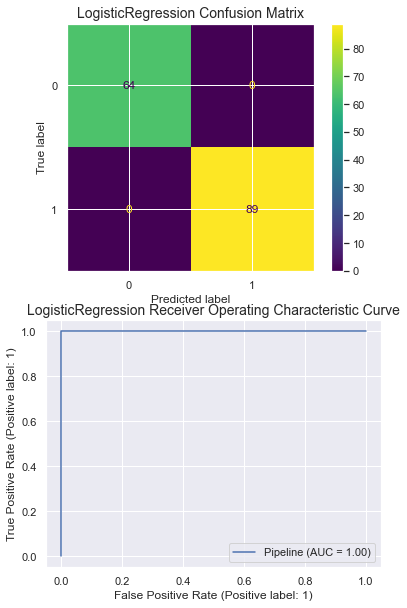

In [78]:
model, y_hat = run_model_gridsearch_CV(X_y_train_test, clf_type='log', verbose=1)

In [146]:
X = spy_cat_3Y_df.drop(['close', 'adj_close', 'open', 'high', 'low', 'volume'], axis=1)
X = X.drop(X.index[0], axis=0)
# y = y_setup.drop(y_setup.index[0]).change
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .20,
        random_state = 729)
print (X,y)

             f_open   f_high    f_low  f_close  f_adj_close   f_volume
date                                                                  
2018-05-02  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0
2018-05-03  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0
2018-05-04  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0
2018-05-07  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0
2018-05-08  2668.00  2674.25  2652.25  2670.25      2670.25  1281751.0
...             ...      ...      ...      ...          ...        ...
2021-05-03  4181.50  4202.50  4181.00  4185.75      4185.75  1256240.0
2021-05-04  4184.25  4185.50  4120.50  4158.25      4158.25  2003587.0
2021-05-05  4158.25  4180.00  4153.00  4160.00      4160.00  1418246.0
2021-05-06  4158.75  4197.25  4140.50  4194.25      4194.25  1751616.0
2021-05-07  4197.50  4232.25  4191.75  4225.25      4225.25  1751616.0

[760 rows x 6 columns] date
2018-05-02    0
2018-05-03    0
2018-05-04    1


### SPY vs SPY Future - one day offset

In [79]:
test = [False]
if test:
    print(True)

Pmdarima_Model.py loaded from {top}/data..
regressions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
True


In [165]:
y_setup = df_1d_back.copy()
y_setup['close_diff'] = y_setup.close.diff()
y_setup['change'] = np.where(y_setup.close_diff >= 0, 1, 0)
y_setup

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume,close_diff,change
date,,,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0,-1.779999,0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0,-0.580017,0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0,3.399994,1
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0,0.900024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400.0,4129.00,4186.75,4127.50,4171.50,4171.50,1509514.0,0.869995,1
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100.0,4170.75,4186.00,4163.75,4179.50,4179.50,1019731.0,-0.089996,0
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900.0,4181.50,4192.50,4166.75,4179.00,4179.00,992029.0,-0.119995,0


In [167]:
X = df_1d_back.drop(['close', 'adj_close', 'open', 'high', 'low', 'volume'], axis=1)
X = X.drop(X.index[0], axis=0)
y = y_setup.drop(y_setup.index[0]).change
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .20,
        random_state = 729)
print (X,y)

             f_open   f_high    f_low  f_close  f_adj_close   f_volume
date                                                                  
2018-05-02  2646.25  2658.00  2623.25  2652.25      2652.25  1323628.0
2018-05-03  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0
2018-05-04  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0
2018-05-07  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0
2018-05-08  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0
...             ...      ...      ...      ...          ...        ...
2021-04-26  4129.00  4186.75  4127.50  4171.50      4171.50  1509514.0
2021-04-27  4170.75  4186.00  4163.75  4179.50      4179.50  1019731.0
2021-04-28  4181.50  4192.50  4166.75  4179.00      4179.00   992029.0
2021-04-29  4180.25  4193.75  4172.75  4176.25      4176.25  1282972.0
2021-04-30  4184.75  4211.00  4168.00  4203.50      4203.50  1746965.0

[783 rows x 6 columns] date
2018-05-02    0
2018-05-03    0
2018-05-04    1


In [168]:
y.isna().sum()

0

In [169]:
numerical_pipeline = Pipeline(steps=[
    ('rs', RobustScaler())
])
                
# categorical_pipeline = Pipeline(steps=[
#     ('ohe', OneHotEncoder( #drop='first',
#                          sparse=False,
#                          handle_unknown='ignore'))
# ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train.columns),
#     ('categorical', categorical_pipeline, X_train.columns)
])


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume'], dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 5 folds for each of 9600 candidates, totalling 48000 fits


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)



{'lr__C': 1.623776739188721, 'lr__class_weight': 'none', 'lr__dual': False, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Classifier:  LogisticRegression
Num features:  6
Model score:  0.5605095541401274
Accuracy score:  0.5605095541401274
Model F1 (micro):  0.5605095541401274
Model F1 (macro):  0.3591836734693878
Model F1 (weighted):  0.4026517613414793
Cross validation score:  [0.59375    0.59375    0.41935484 0.5483871  0.58064516]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.56      1.00      0.72        88

    accuracy                           0.56       157
   macro avg       0.28      0.50      0.36       157
weighted avg       0.31      0.56      0.40       157



/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being 

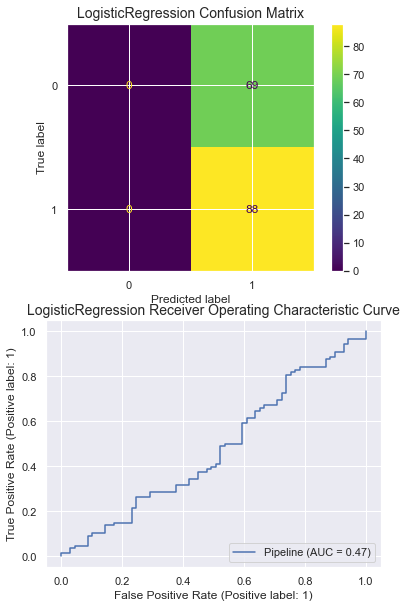

In [180]:
pipe_lr = Pipeline(steps=[
    ('trans', trans),
    ('lr', LogisticRegression(random_state=1, max_iter=500))
])
print(pipe_lr)

params_grid_lr = {'lr__penalty' : ['l1', 'l2','elasticnet'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=4, n_jobs=-1)

lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train.columns, best_lr_clf, 'LogisticRegression', X_test, y_test, binary=True)
Audio(sound_file, autoplay=True)